# Run this jupyter notebook step by step (this note book is for ISIC skin cancer)

first, create conda environment with containing Python using following command:
```
in terminal:
conda create -n CDEP python
```
Enter 'y' in install packages and then enter the created enviroment using this command:
```
conda activate CDEP
```
then run the following commands to install ipykernel ,so you can specify in the jupyter notebook to use CDEP enviroment as kernel:
```
pip install ipykernel
python -m ipykernel install --user --name CDEP --display-name "CDEP"
```
then in this jupyter notebook in kernel click change kernel and select CDEP

# install the following packages in the terminal
first, enter the CDEP environment using the following command:
```
conda activate CDEP
```
and run the following commands to install the required libraries (run one by one):
```
pip install requests
pip install tqdm
conda install -c conda-forge ipywidgets
pip install jupyter_contrib_nbextensions
conda install pandas
pip install gdown
conda install pillow
pip install opencv-python
conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia
pip install --force-reinstall charset-normalizer==3.1.0
python -m pip install -U scikit-image
pip install -U scikit-learn
conda install -c conda-forge matplotlib
pip install seaborn
```

# then run the following code to import libraries:

In [1]:
%load_ext autoreload

%autoreload 2
from isic_api import ISICApi
import os
import json
import csv
from tqdm.autonotebook import tqdm
with open('config.json') as json_file:
    data = json.load(json_file)

import pandas as pd
import numpy as np
import requests
from pathlib import Path
from zipfile import ZipFile
import gdown
from zipfile import ZipFile
import os

from PIL import Image
from os.path import join as oj
import cv2
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, ConcatDataset
from torch import nn
import torchvision.models as models


C:\Users\Hannes\AppData\Local\Temp\ipykernel_13208\1753767253.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Run this code to get the data meta data related to first 1000 images of skin data:
At the end of this code you should have imageList contating the metadatas of 1007 malignant images and 2367 benign images.
after running this you should see meta_random.csv file in following directory: data/ISIC/

In [2]:
def count_malignant(imageList):
    malignant = 0
    for data in imageList:
        if 'metadata' in data and 'clinical' in data['metadata'] and 'benign_malignant' in data['metadata']['clinical']:
            if data['metadata']['clinical']['benign_malignant'] == 'malignant':
                malignant+=1
    return malignant

api = ISICApi(username=None, password=None)
data_path = data["data_folder"]
num_imgs = data["num_imgs"]

if not os.path.exists(data_path):
    os.makedirs(data_path)
imageList = []
count = 0
malignants  = 0
while malignants < 1000:
    if count == 0:
        temp = api.getJson('images/?limit=' + str(num_imgs) +'&offset=0&sort=name')
        imageList = temp['results']
        next_page = temp['next'].split("images")[1]
        malignants += count_malignant(imageList)
    else:
        temp = api.getJson('images' + next_page)
        imageList = imageList + temp['results']
        next_page = temp['next'].split("images")[1]
        malignants += count_malignant(temp['results'])
    print(f"number of malignant images that fetched from API: {malignants}")
    count+=1
    
# Determine the union of all image metadata fields
metadataFields = set(
        field
        for imageL in imageList
        for field in imageL['metadata']['clinical'].keys()
    )


metadataFields = ['isic_id'] + sorted(metadataFields)
outputFileName = "meta_random"
#%%
outputFilePath = os.path.join(data_path, outputFileName)
# Write the metadata to a CSV
print('Writing metadata to CSV: %s' % outputFileName+'.csv')
with open(outputFilePath+'.csv', 'w') as outputStream:
    csvWriter = csv.DictWriter(outputStream, metadataFields)
    csvWriter.writeheader()
    for imageL in imageList:
        rowDict = imageL['metadata']['clinical'].copy()
        rowDict['isic_id'] = imageL['isic_id']
        csvWriter.writerow(rowDict)
df = pd.read_csv('../../data/ISIC/meta_random.csv')
print(df.benign_malignant.value_counts())
del df


number of malignant images that fetched from API: 7
number of malignant images that fetched from API: 12
number of malignant images that fetched from API: 12
number of malignant images that fetched from API: 12
number of malignant images that fetched from API: 17
number of malignant images that fetched from API: 27
number of malignant images that fetched from API: 36
number of malignant images that fetched from API: 74
number of malignant images that fetched from API: 113
number of malignant images that fetched from API: 180
number of malignant images that fetched from API: 247
number of malignant images that fetched from API: 307
number of malignant images that fetched from API: 336
number of malignant images that fetched from API: 401
number of malignant images that fetched from API: 459
number of malignant images that fetched from API: 521
number of malignant images that fetched from API: 555
number of malignant images that fetched from API: 576
number of malignant images that fetch

# Now in the following code you want to download meta data of images that contain patches:
(I only download 2000 images with patches)
it take a little time to fetch all meta data

In [3]:
api = ISICApi(username=None, password=None)
print('Fetching metadata for noisy images')
imageDetails_noisy = []
with open('./image_ids_patches.txt', 'r') as file:
    lines = file.readlines()

for line in tqdm(lines[:2000]):
    temp = api.getJson('images/'+line.strip().split(".")[0]+"/")
    imageDetail = api.getJson('images/%s' % temp['isic_id'])
    imageDetails_noisy.append(imageDetail)

Fetching metadata for noisy images


  0%|          | 0/2000 [00:00<?, ?it/s]

now save results to /data/ISIC/meta_patches.csv:

In [5]:
metadataFields = set(
        field
        for imageDetail in imageDetails_noisy
        for field in imageDetail['metadata']['clinical'].keys()
    )


metadataFields = ['isic_id'] + sorted(metadataFields)
outputFileName = "meta_patches"
#%%
outputFilePath = os.path.join(data_path, outputFileName)
# Write the metadata to a CSV
print('Writing metadata to CSV: %s' % outputFileName+'.csv')
with open(outputFilePath+'.csv', 'w') as outputStream:
    csvWriter = csv.DictWriter(outputStream, metadataFields)
    csvWriter.writeheader()
    for imageDetail in imageDetails_noisy:
        rowDict = imageDetail['metadata']['clinical'].copy()
        rowDict['isic_id'] = imageDetail['isic_id']
        csvWriter.writerow(rowDict)

Writing metadata to CSV: meta_patches.csv


# merge meta_patches.csv and meta_random.csv to single file --> meta.csv

In [6]:
file1 = '../../data/ISIC/meta_random.csv'
file2 = '../../data/ISIC/meta_patches.csv'
output_file = '../../data/ISIC/meta.csv'
index_column = 'isic_id'
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

if index_column not in df1.columns or index_column not in df2.columns:
    raise ValueError(f"Column '{index_column}' must exist in both CSV files")
df2_filtered = df2[~df2[index_column].isin(df1[index_column])]
merged_df = pd.concat([df1, df2_filtered], ignore_index=True)
merged_df.to_csv(output_file, index=False)
merged_df.to_csv(output_file, index=False)

print(f"Merged file saved as {output_file}")

Merged file saved as ../../data/ISIC/meta.csv


the final files that we should download in rest of codes is like this: (4367 benign and 1007 malignant)

In [7]:
df = pd.read_csv('../../data/ISIC/meta.csv')
print(df.benign_malignant.value_counts())
del df

benign_malignant
benign                     4367
malignant                  1007
indeterminate/benign         35
indeterminate/malignant      27
indeterminate                20
Name: count, dtype: int64


# download images in meta.csv and save those in /data/ISIC/raw:
it also take a lot of time (but wait until the end)

In [8]:
imageDetails = imageList + imageDetails_noisy

api = ISICApi(username=None, password=None)
data_path = data["data_folder"]
savePath = os.path.join(data_path, 'raw')

if not os.path.exists(savePath):
    os.makedirs(savePath)

for detail in tqdm(imageDetails):
    url = detail['files']['full']['url']
    img_data = requests.get(url).content
    imageFileOutputPath = os.path.join(savePath, '%s.jpg' % detail['isic_id'])
    if not(Path(imageFileOutputPath).exists()):
        with open(imageFileOutputPath, 'wb') as imageFileOutputStream:
            imageFileOutputStream.write(img_data)


  0%|          | 0/5500 [00:00<?, ?it/s]

# run this for downloading the masks
theese images show the patches in images using mask. after running the following cell u can look at them at /Data/ISIC/segmentation

In [9]:
url = "https://drive.google.com/uc?id=1L-2y4rMQDQ4uAnotWGbqndv8eDF7MHuT"
output = "../../data/ISIC/segmentation.zip"
gdown.download(url, output, quiet=False)

with ZipFile('../../data/ISIC/segmentation.zip', 'r') as f:
    f.extractall('../../data/ISIC/')

os.remove("../../data/ISIC/segmentation.zip")

Downloading...
From (original): https://drive.google.com/uc?id=1L-2y4rMQDQ4uAnotWGbqndv8eDF7MHuT
From (redirected): https://drive.google.com/uc?id=1L-2y4rMQDQ4uAnotWGbqndv8eDF7MHuT&confirm=t&uuid=36352fe4-472d-44a1-bc30-6e478bc1f04c
To: c:\Users\Hannes\Desktop\VSCode Projects\Studium\Seminar\CDEP2\data\ISIC\segmentation.zip
100%|██████████| 35.1M/35.1M [00:08<00:00, 3.99MB/s]


# seprate benign and malignant in different folder:
after running following cell, cancer and non_cancer cell should be seprated and resized into 2 different folder in /data/ISIC/processed/cancer and no_cancer

In [10]:
data_path = data["data_folder"]
img_path = os.path.join(data_path, "raw")
processed_path = os.path.join(data_path, "processed")
segmentation_path = os.path.join(data_path, "segmentation")
benign_path = os.path.join(processed_path, "no_cancer")
malignant_path = os.path.join(processed_path, "cancer")
os.makedirs(processed_path,exist_ok = True)
os.makedirs(benign_path,exist_ok = True)
os.makedirs(segmentation_path,exist_ok = True)
os.makedirs(malignant_path,exist_ok = True)

list_of_meta = []

with open(oj(data_path, "meta.csv"), newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    next(spamreader)
    for row in spamreader:
        list_of_meta.append(row)  


#%%
list_benign_files = []
for line in list_of_meta:
    if len(line) > 0 and line[4] == 'benign':
        list_benign_files.append(line[0] + ".jpg")
list_mal_files = []
for line in list_of_meta:
    if len(line) > 0 and line[4] == 'malignant':
        list_mal_files.append(line[0] + ".jpg")
#%%

def resize_and_save(my_list, my_folder):
    for i,file_name in tqdm(enumerate(my_list)):
        try:
            img = cv2.imread(oj(img_path, file_name))
            resized_img = cv2.resize(img, (299, 299))  # Resize the image to (299, 299)
            cv2.imwrite(oj(my_folder, file_name), resized_img)
        except:
            pass
resize_and_save(list_mal_files, malignant_path)
resize_and_save(list_benign_files, benign_path)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

# in the following cell the code calculates last layer of the VGG16 model for each image, and for images that contain patches, it also calculate rel and irrel of features

at the end of this part you should see 3 npy file in /data/ISIC/calculated_features

In [11]:
import torch
import torchvision
import torchvision.datasets as datasets
import sys
import numpy as np
import torch.utils.data as utils
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pickle as pkl
from os.path import join as oj
import os
from torch.utils.data import Subset
import csv
import numpy as np
sys.path.append('../../src/')
from skimage.morphology import dilation
import cd
from shutil import copyfile
from os.path import join as oj
from PIL import Image
from tqdm import tqdm
from skimage.color import rgb2gray
import torchvision.models as models
from torch import nn    
from torch.nn import AdaptiveAvgPool2d
import json
with open('config.json') as json_file:
    data = json.load(json_file)

In [12]:
data_path = data["data_folder"]
processed_path = os.path.join(data_path, "processed")
benign_path = os.path.join(processed_path, "no_cancer")
malignant_path = os.path.join(processed_path, "cancer")
feature_path = os.path.join(data_path, "calculated_features")
segmentation_path = os.path.join(data_path, "segmentation")
os.makedirs(feature_path,exist_ok = True)
#%%
# used for converting to the range VGG16 is used to
mean = np.asarray([0.485, 0.456, 0.406])
std = np.asarray([0.229, 0.224, 0.225])

device = torch.device("cuda")
#%%


list_of_img_names = os.listdir(benign_path)


model = models.vgg16(pretrained=True).to(device).eval()

img_features = np.empty((len(list_of_img_names), 25088))
cd_features = -np.ones((len(list_of_img_names), 2, 25088)) # rel, irrel
avg_layer = torch.nn.AdaptiveAvgPool2d((7,7))
from skimage.morphology import square
my_square = square(20)
with torch.no_grad():
    for i in tqdm(range(len(list_of_img_names))):
        if not(list_of_img_names[i].startswith('.')):
            img = Image.open(oj(benign_path, list_of_img_names[i]))
            img_torch = torch.from_numpy(((np.asarray(img)/255.0 -mean)/std).swapaxes(0,2).swapaxes(1,2))[None,:].cuda().float()
            img.close()
            img_features[i] = avg_layer(model.features(img_torch)).view(-1).cpu().numpy()
            if os.path.isfile(oj(segmentation_path, list_of_img_names[i])):
                seg = Image.open(oj(segmentation_path, list_of_img_names[i]))
                blob =  dilation((np.asarray(seg)[:,:, 0] > 100).astype(np.uint8),my_square).astype(np.float32)
                
                rel, irrel =cd.cd_vgg_features(blob, img_torch, model)
                cd_features[i, 0] = rel[0].cpu().numpy()
                cd_features[i, 1] = irrel[0].cpu().numpy()



with open(oj(feature_path, "not_cancer.npy"), 'wb') as f:
    np.save(f, img_features)
with open(oj(feature_path, "not_cancer_cd.npy"), 'wb') as f:
    np.save(f, cd_features)
 


list_of_img_names = os.listdir(malignant_path)
img_features = np.empty((len(list_of_img_names), 25088))
with torch.no_grad():
    for i in tqdm(range(len(list_of_img_names))):
        if not(list_of_img_names[i].startswith('.')):
            img = Image.open(oj(malignant_path, list_of_img_names[i]))
            img_torch = torch.from_numpy(((np.asarray(img)/255.0 -mean)/std).swapaxes(0,2).swapaxes(1,2))[None,:].cuda().float()
            img.close()
            img_features[i] = avg_layer(model.features(img_torch)).view(-1).cpu().numpy()
with open(oj(feature_path, "cancer.npy"), 'wb') as f:
    np.save(f, img_features)

c:\Users\Hannes\anaconda3\envs\CDEP2\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Hannes\anaconda3\envs\CDEP2\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/4367 [00:00<?, ?it/s]c:\Users\Hannes\Desktop\VSCode Projects\Studium\Seminar\CDEP2\isic-skin-cancer\ISIC\../../src\cd.py:498: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at C:\cb\p

# train.py

In [16]:
import torch
from torch import nn
import torch.optim as optim
import torchvision.models as models
import sys
import pickle as pkl
import os
import argparse
from numpy.random import randint
import time
import copy
from tqdm import tqdm
sys.path.append('../../src')
import utils
import cd
import json
torch.backends.cudnn.deterministic = True #this makes results reproducible. 
with open('config.json') as json_file:
    data = json.load(json_file)

# very important:
Change values of regularizer_rate with different values (the repository used -1, 0.0, and 10) and run this section for each regularizer_rate.

If you change values of regularizer_rate 3 times and run the code of this section 3 times, you should see 6 files in this directory: /models/ISIC_new/ with these extensions: .pkl .pt

In [23]:
regularizer_rate = 5

In [24]:
model_path = os.path.join(data["model_folder"], "ISIC_new")
if not os.path.exists(model_path):
    os.makedirs(model_path)
dataset_path =os.path.join(data["data_folder"],"calculated_features")

 
# Training settings
description='ISIC Skin cancer for CDEP'
batch_size = 32
epochs = 100
num_epochs = epochs
lr = 1e-2
momentum = 0.9
seed = 42

device = torch.device(0)

torch.manual_seed(seed);
model = models.vgg16(pretrained=True)
model.classifier[-1] = nn.Linear(4096, 2)
model = model.classifier.to(device)
datasets, weights = utils.load_precalculated_dataset(dataset_path)
if regularizer_rate ==-1: # -1 means that we train only on data with no patches
    datasets['train'] = datasets['train_no_patches']

dataset_sizes= {x:len(datasets[x]) for x in datasets.keys()}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in datasets.keys()}





weights = torch.tensor(weights).to(device)

params_to_update = model.parameters()

criterion = nn.CrossEntropyLoss(weight = weights.double().float())


optimizer_ft = optim.SGD(params_to_update, lr=lr, momentum=momentum)

def train_model(model,dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()
    val_acc_history = []
    val_loss_history = []
    train_loss_history = []
    
    train_acc_history = []
    train_cd_history= []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1000.0
    patience = 3
    cur_patience = 0


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_loss_cd = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels, cd_features) in tqdm(enumerate(dataloaders[phase])):
    
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                cd_features = cd_features.to(device)
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                    
                        add_loss = torch.zeros(1,).cuda()
                        if regularizer_rate > 0:
                        
                            mask  = (cd_features[:, 0,0] != -1).bool()
                            if mask.any():
                                rel, irrel = cd.cd_vgg_classifier(cd_features[:,0], cd_features[:,1], inputs, model) # feature maps for rel and irrel
                   
                                cur_cd_loss = torch.nn.functional.softmax(torch.stack((rel[:,0].masked_select(mask),irrel[:,0].masked_select(mask)), dim =1), dim = 1)[:,0].mean() # benign
                                cur_cd_loss +=torch.nn.functional.softmax(torch.stack((rel[:,1].masked_select(mask),irrel[:,1].masked_select(mask)), dim =1), dim = 1)[:,0].mean() # malign
                                add_loss = cur_cd_loss/2

                        (loss+regularizer_rate*add_loss).backward()
                        # print how much memory is used
                        #print(torch.cuda.memory_allocated()/(np.power(10,9)))
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_loss_cd +=add_loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_cd_loss = running_loss_cd / dataset_sizes[phase]
       
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
  
            
            print('{} Loss: {:.4f} Acc: {:.4f} CD Loss : {:.4f}'.format(
                phase, epoch_loss, epoch_acc, epoch_cd_loss))

            # deep copy the model
            if phase == 'val':
                val_acc_history.append(epoch_acc.item())
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_cd_history.append(epoch_cd_loss)
                train_acc_history.append(epoch_acc.item())
                
            if phase == 'val':
                if epoch_loss < best_loss:
            
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    cur_patience = 0
                else:
                    cur_patience+=1
        if cur_patience >= patience:
            break
             
                

 

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))



  
    hist_dict = {}
    hist_dict['val_acc_history'] = val_acc_history
    hist_dict['val_loss_history'] = val_loss_history
    hist_dict['train_acc_history'] = train_acc_history
    hist_dict['train_loss_history'] = val_loss_history
    hist_dict['train_cd_history'] = train_cd_history
    model.load_state_dict(best_model_wts)
    return model,hist_dict 

model, hist_dict = train_model(model, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs)

hist_dict['AUC (no patches)'],hist_dict['F1 score (no patches)'] =utils.get_auc_f1(model, datasets['test_no_patches'])

hist_dict['AUC (patches)'],hist_dict['F1 score (patches)'] =utils.get_auc_f1(model, datasets['test'])



pid = ''.join(["%s" % randint(0, 9) for num in range(0, 20)])
torch.save(model.state_dict(),oj(model_path, pid + ".pt"))

hist_dict['pid'] = pid
hist_dict['regularizer_rate'] = regularizer_rate
hist_dict['seed'] = seed
hist_dict['batch_size'] = batch_size
hist_dict['learning_rate'] = lr
hist_dict['momentum'] = momentum
pkl.dump(hist_dict, open(os.path.join(model_path , pid +  '.pkl'), 'wb'))




c:\Users\Hannes\anaconda3\envs\CDEP2\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Hannes\anaconda3\envs\CDEP2\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/99
----------


135it [00:14,  9.32it/s]


train Loss: 0.4013 Acc: 0.8144 CD Loss : 0.0068


17it [00:03,  4.44it/s]


val Loss: 0.3814 Acc: 0.8492 CD Loss : 0.0002
Epoch 1/99
----------


135it [00:13,  9.70it/s]


train Loss: 0.2439 Acc: 0.8716 CD Loss : 0.0001


17it [00:03,  4.57it/s]


val Loss: 0.3981 Acc: 0.8119 CD Loss : 0.0000
Epoch 2/99
----------


135it [00:13,  9.73it/s]


train Loss: 0.1575 Acc: 0.9221 CD Loss : 0.0000


17it [00:03,  4.55it/s]


val Loss: 0.4429 Acc: 0.8399 CD Loss : 0.0000
Epoch 3/99
----------


135it [00:13,  9.65it/s]


train Loss: 0.0934 Acc: 0.9586 CD Loss : 0.0000


17it [00:03,  4.58it/s]


val Loss: 0.7364 Acc: 0.8622 CD Loss : 0.0000
Training complete in 1m 14s
Best val loss: 0.381398


# this part of code is copy of analyze_isic.ipynb

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
from os.path import join as oj

sys.path.append("../../src/")
from utils import load_precalculated_dataset,get_output, load_img_dataset,get_auc_f1,calc_weights
import numpy as np
from torchvision import  transforms
import pickle as pkl

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os
from numpy.random import randint
import time
from torchvision import models
import copy
from tqdm import tqdm
from torch import nn
import pandas as pd
import seaborn as sns
sns.set()
import torch.nn.functional as F
from PIL import Image
import torch
device = torch.device("cuda")
pd.set_option('display.precision', 2)


In [2]:
save_path = "../../results_for_export"
trained_model_folder = '../../models/ISIC_new'
fnames = sorted([oj(trained_model_folder, fname) for fname in os.listdir(trained_model_folder) if 'pkl'  in fname]) 
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 
results = pd.concat(results_list, axis=1, sort = True).T.infer_objects() 
idx_best_loss = [np.asarray(x).argmax() for x in results['val_acc_history']]  
results['final_acc'] = [x[idx_best_loss[i]] for i,x in enumerate(results['val_acc_history'])] 


In [3]:
results[['regularizer_rate',
                       'final_acc', 
                       'AUC (no patches)',
                       'F1 score (no patches)',
                       'AUC (patches)',
                       'F1 score (patches)']].groupby('regularizer_rate').mean()

,final_acc,AUC (no patches),F1 score (no patches),AUC (patches),F1 score (patches)
regularizer_rate,,,,,
-1.0,0.87,0.87,0.68,0.87,0.64
0.0,0.88,0.86,0.67,0.93,0.67
0.1,0.87,0.87,0.67,0.93,0.67
0.5,0.87,0.87,0.68,0.93,0.68
2.0,0.87,0.87,0.67,0.93,0.67
5.0,0.86,0.88,0.69,0.93,0.69
10.0,0.88,0.88,0.71,0.94,0.71


In [4]:
# take the best network for each to visualize heatmaps 
results[['regularizer_rate','AUC (patches)','pid']][results.regularizer_rate >=0].sort_values('AUC (patches)')

,regularizer_rate,AUC (patches),pid
0,0.0,0.93,11004384772815077431
1,0.5,0.93,26062302634442230757
6,0.1,0.93,72763208868365070257
5,2.0,0.93,63440664688626557862
2,5.0,0.93,53076577306138671438
4,10.0,0.94,62286523804873352841


In [5]:

datasets,_ = load_precalculated_dataset("../../data/ISIC/calculated_features")
device = torch.device(0)
model = models.vgg16(pretrained=True)
model.classifier[-1] = nn.Linear(4096, 2)
model = model.to(device).eval()


c:\Users\Hannes\anaconda3\envs\CDEP2\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Hannes\anaconda3\envs\CDEP2\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
f1_nopatches_dict = {}
auc_nopatches_dict = {}
f1_patches_dict = {}
auc_patches_dict = {}
for index, row in results[['regularizer_rate','pid',]].iterrows():
    fname = oj(trained_model_folder, str(row['pid']) + '.pt')
    auc_nopatches_dict[row['pid']], f1_nopatches_dict[row['pid']] = get_auc_f1(model, datasets['test_no_patches'], fname = fname, )
    auc_patches_dict[row['pid']], f1_patches_dict[row['pid']] = get_auc_f1(model, datasets['test'], fname = fname, )
    
# update values 
results['AUC (no patches)'] =[auc_nopatches_dict[x] for x in results['pid']]
results['F1 score (no patches)'] =[f1_nopatches_dict[x] for x in results['pid']]
results['AUC (patches)'] =[auc_patches_dict[x] for x in results['pid']]
results['F1 score (patches)'] =[f1_patches_dict[x] for x in results['pid']]

# GradCam

In [7]:
import sys
sys.path.append("../../src/")
from tqdm import tqdm_notebook
from gradcam import GradCam
import torchvision.models as models
from PIL import Image
from utils import load_img_dataset

In [8]:
img_dataset = load_img_dataset("../../data/ISIC/processed/") # this only loads the test set
mean = np.asarray([0.485, 0.456, 0.406]) 
std = np.asarray([0.229, 0.224, 0.225])

### in the following cell you should replace the .pt file with the one that had best performance

In [9]:

model_no_reg = models.vgg16(pretrained=True)
model_no_reg.classifier[-1] = nn.Linear(4096, 2)
model_no_reg = model_no_reg.eval()
model_no_reg.classifier.load_state_dict(torch.load('../../models/ISIC_new/11004384772815077431.pt')); # best performing vanilla model, regularizer rate = -1
# model_no_reg.classifier.load_state_dict(torch.load('../../models/ISIC_new/58881224264226433874.pt')); # best performing vanilla model, regularizer rate = -1
model_reg = models.vgg16(pretrained=True)
model_reg.classifier[-1] = nn.Linear(4096, 2)
model_reg = model_reg.eval()
model_reg.classifier.load_state_dict(torch.load('../../models/ISIC_new/62286523804873352841.pt')); # best performing CDEP model, regularizer rate = 10
# model_reg.classifier.load_state_dict(torch.load('../../models/ISIC_new/62286523804873352841.pt')); # best performing CDEP model, regularizer rate = 10

c:\Users\Hannes\anaconda3\envs\CDEP2\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Hannes\anaconda3\envs\CDEP2\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
my_list_all = [img_dataset[i][0] for i in range(len(img_dataset)) ]
my_list_targets_all = [img_dataset[i][1] for i in range(len(img_dataset)) ]

In [11]:
model_reg = model_reg.cuda()
model_no_reg = model_no_reg.cuda()

grad_cam_noreg = GradCam(model_no_reg, target_layer=29)
grad_cam_reg = GradCam(model_reg, target_layer=29)

In [12]:
triples = []
for img, target in tqdm(zip(my_list_all[:1000], my_list_targets_all[:1000])):
    img.requires_grad= True
    test_img = img.cuda()
    test_img = test_img[None, :, :224, :224]
    img_np = img[:, :224, :224].detach().cpu().numpy().transpose(1,2,0)*std[None, None, :] + mean[None, None, :]
    reg_saliency = grad_cam_reg.generate_cam(test_img, target)
    vanilla_saliency = grad_cam_noreg.generate_cam(test_img, target)
    triples.append((img_np, vanilla_saliency, reg_saliency, target))

0it [00:00, ?it/s]c:\Users\Hannes\anaconda3\envs\CDEP2\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
538it [00:36, 14.77it/s]


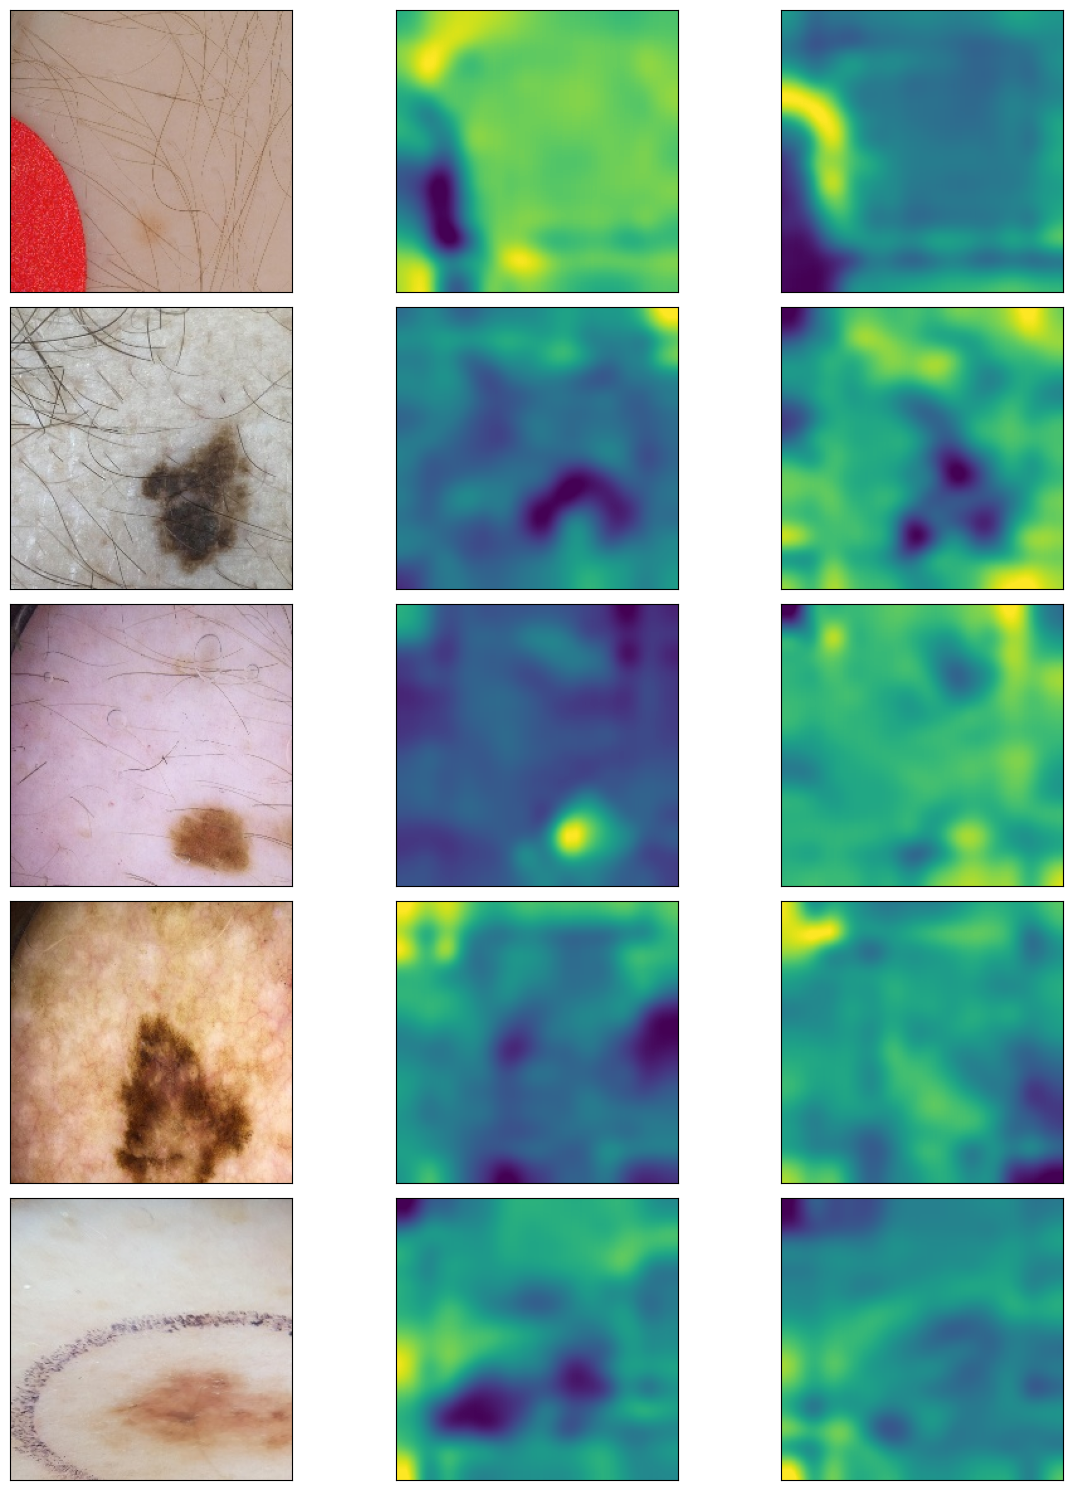

In [14]:

sns.reset_orig()
idxs = [1,2,3,4,5] # supposed to be the first ids that have a patch, but they aren't :(
num_rows = len(idxs)

fig, axes = plt.subplots(num_rows,3, figsize=  (4.2*3, num_rows*3))

for i, (idx) in enumerate(idxs):
    original_img, vanilla_sal, reg_sal, true_class = triples[idx]

    axes[i,0].imshow(np.clip(original_img,0,1))
    axes[i,0].tick_params(axis='both', which='both', bottom=False, left = False, top=False, labelbottom=False, labelleft = False)

    axes[i,1].imshow( vanilla_sal, cmap = plt.get_cmap("viridis"),)
    axes[i,1].tick_params(axis='both', which='both', bottom=False, left = False, top=False, labelbottom=False, labelleft = False)
    axes[i,2].imshow(reg_sal, cmap =plt.get_cmap("viridis"))

    axes[i,2].tick_params(axis='both', which='both', bottom=False, left = False, top=False, labelbottom=False, labelleft = False)

plt.tight_layout()
save_path = "../results_for_export"
# fig.savefig(oj(save_path,"gradCAM"))